<a href="https://colab.research.google.com/github/DanieleFoscarin/HDA2021/blob/yamnet/Remake_ESC50_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

reference YAMNet https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/transfer_learning_audio.ipynb#scrollTo=k2yleeev645r

In [1]:
from pathlib import Path
from scipy.io import wavfile
from IPython.display import Audio
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
import librosa
from tqdm import tqdm, tqdm_notebook, notebook
import gc
import time 
# import numba
import os
import scipy.fftpack
import cv2
import random


import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence, SequenceEnqueuer   # try enquerer that uses parallelism
from tensorflow import keras

import tensorflow_hub as hub

#import model 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

sr = 44100
sr = 16000
sr = 22050

In [2]:
! pip install icecream --quiet
from icecream import ic

In [3]:
! pip install samplerate --quiet
import samplerate

     |████████████████████████████████| 4.0MB 2.9MB/s 


In [ ]:
# ! pip install optuna --quiet
# import optuna

In [4]:
!pip install livelossplot --quiet
from livelossplot import PlotLossesKeras

# Get Dataset

In [5]:
# Clone the entire repo.
!git clone https://github.com/karolpiczak/ESC-50.git


Cloning into 'ESC-50'...
remote: Enumerating objects: 4154, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 4154 (delta 10), reused 0 (delta 0), pack-reused 4136
Receiving objects: 100% (4154/4154), 878.78 MiB | 21.28 MiB/s, done.
Resolving deltas: 100% (257/257), done.
Checking out files: 100% (2011/2011), done.


In [6]:
ROOT = '/content/ESC-50/audio/'

data_info = pd.read_csv(ROOT+"../meta/esc50.csv")

#make a category dictionary
category_dict = dict(zip(data_info['target'], data_info['category']))
# to_onehot_dict = dict(zip(range(0,50), np.))

#remove unused coumn and add other
# aug_col = np.zeros((len(data_info),1))
# mixup_col = -1 * np.ones((len(data_info),1))
# data_info.drop('esc10', axis=1, inplace=True)
# data_info.drop('src_file', axis=1, inplace=True)
# data_info.drop('take', axis=1, inplace=True)

# data_info['augmentation'] = aug_col
# data_info['mixup'] = mixup_col

# # one hot encoding from category
# data_info = pd.get_dummies(data_info, columns=["category"], prefix='', prefix_sep='') 


data_info

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


ic| len(audio_loader): 2000


<class 'pandas.core.series.Series'>
washing_machine


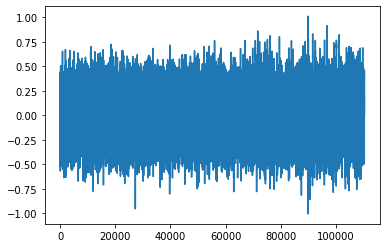

In [7]:
class AudioLoader():
    def __init__(self, df, root, format1=False, downsample=True):
        self.df = df
        self.root = root
        self.format1 = format1
        self.downsample = downsample

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        _, this_audio = wavfile.read(os.path.join(self.root, self.df['filename'][idx]))
        if self.downsample:
            this_audio = samplerate.resample(this_audio, 22050/44100, converter_type='sinc_fastest')
        if self.format1:
            this_audio = this_audio / 32768
        return this_audio

    def get_info(self, idx, list=False):
        if list:
            out = self.df.iloc[idx].to_list()
        else:
            out = self.df.iloc[idx]
        return out


audio_loader = AudioLoader(data_info, ROOT, True)
ic(len(audio_loader))
plt.plot(audio_loader[123])
print(type(audio_loader.get_info(123)))
print(audio_loader.get_info(123)['category'])

In [8]:
# ! mkdir -p mel_storage
# path_mel = "/content/mel_storage/"

# ! mkdir -p mfcc_storage
# path_mfcc = "/content/mfcc_storage/"

# ! mkdir -p chroma_storage
# path_chroma = "/content/chroma_storage/"

# path_list = [path_mel, path_mfcc, path_chroma]

!mkdir -p feature_storage
path_batch = "/content/feature_storage/"

path_drive = '/content/drive/MyDrive/UNI_ICT/HDA/data/' 

!mkdir -p sandbox
path_sandbox = "/content/sandbox/"

# Preprocessing functions

## Removing silence

removing silence at the beginning or at the end of the audio clip

In [9]:
def removeSilence(signal, fill_silence=False):
    """
    Remove the leading and trailing zeros in an array,
    Parameters:
        signal: array,
        fill_silence: boolean, if True it repeats the non zero part until the 
            size of the output array is the same as the input array
    Return:
        an array

    """
    
    trimmed = np.trim_zeros(signal)
    if not fill_silence:
        return trimmed
    if fill_silence:
        lt = len(trimmed)
        ls = len(signal)
        # ic(lt,ls)
        if lt < ls:
          trimmed = np.tile(trimmed, int(np.ceil(ls/lt)))
          trimmed = trimmed[:ls]  
        return trimmed

# ic(len(audio_list[0]))
# a = removeSilence(audio_list[0], fill_silence=True)
# librosa.display.waveplot(a, sr=SR)
# ic(len(audio_list[0]))
# ic(len(a))
# # IPython.display.Audio(a, rate=sr)

## compute spectral features

ic| np.shape(rms): (502, 1), np.shape(cont): (9, 502)
ic| FRAMES: 502
ic| np.min(cont): -1.2657821235320277
    np.max(cont): 0.9994436998280796


(-1.2657821235320277, 0.9994436998280796)

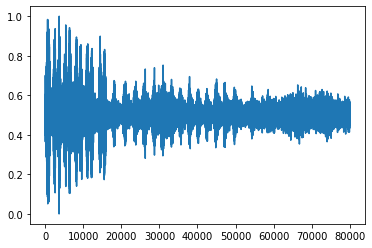

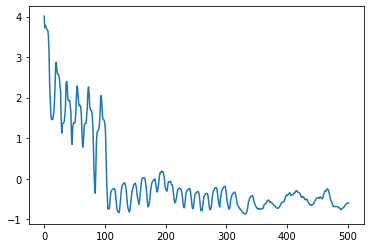

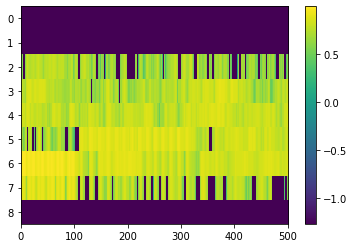

In [10]:
def features3(audio, sr, bands=96,):
    def normalize01(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    def standardize(data):
        return (data - np.mean(data))/np.std(data)

    

    # this_mel = librosa.amplitude_to_db(librosa.feature.melspectrogram(audio.astype('float32'), sr=sr, hop_length=int(sr*0.01), n_mels=bands ))
    # this_mel = standardize(this_mel)

    # this_diff_mel = np.concatenate((np.diff(this_mel, n=1, axis=1), np.zeros((this_mel.shape[0],1))), axis=1)
    # this_diff_mel = standardize(this_diff_mel)

    # # this_diff_mel2 = np.concatenate((np.diff(this_mel, n=2, axis=1), np.zeros((this_mel.shape[0],2))), axis=1)
    # # this_diff_mel2 = standardize(this_diff_mel2)

    this_stft_o = librosa.amplitude_to_db(np.abs(librosa.stft(audio.astype('float32'), hop_length=int(sr*0.01))))
    # this_stft = cv2.resize(this_stft_o, dsize=(this_mel.shape[1], bands))
    # this_stft = standardize(this_stft)
    
    n_bands = 8
    fmin = np.floor(sr/(2**n_bands))
    this_cont = librosa.feature.spectral_contrast(S=this_stft_o, sr=sr, hop_length=int(sr*0.01), fmin=fmin, n_bands=n_bands) #fmin=150 with sr=44100
    this_cont = standardize(this_cont)

    this_rms = librosa.feature.rms(audio, hop_length=int(sr*0.01))
    this_rms = standardize(this_rms)
    this_rms = np.transpose(this_rms, axes=[1,0])

    # features = [normalize01(this_mel), normalize01(this_diff_mel), normalize01(this_stft)]
    # features = [this_mel, this_diff_mel, this_stft]
    # this_rms = normalize01(this_rms)
    # this_cont = normalize01(this_cont)
    audio = samplerate.resample(audio, 16000/22050, converter_type='sinc_fastest')

    # ic(np.shape(this_mel), np.shape(this_diff_mel), np.shape(this_stft))
    return normalize01(audio), this_rms, this_cont


audio, rms, cont = features3(audio_loader[1], sr)
# ic(np.shape(feat))
ic(np.shape(rms), np.shape(cont))
FRAMES = np.shape(rms)[0]
ic(FRAMES)

plt.figure()
plt.plot(audio)

plt.figure()
plt.plot(rms)

plt.figure()
plt.imshow(cont, interpolation='nearest', aspect='auto')
plt.colorbar()

ic(np.min(cont), np.max(cont))

Three in one feature extraction function

In [11]:
def audio_aug2(y, sr=sr, low_ps=-3.5, high_ps=3.5, low_ts=0.8, high_ts=1):
    '''It return a signal with random pitch shift ot time strecth '''

    choice = int(np.random.randint(2))
    if choice == 0:
        step = np.random.uniform(low=low_ps, high=high_ps)
        ya = librosa.effects.pitch_shift(y, sr=sr, n_steps=step)
    elif choice == 1:
        rate = np.random.uniform(low=low_ts, high=high_ts)
        ya = librosa.effects.time_stretch(y, rate)

    ya = ya[:y.shape[0]]
    return ya

def features_preprocessor(audio_loader, path, df, yamnet, augmentation=0):
    # mel_names = []
    # mfcc_names = []
    # chroma_names = []
    # data_info_aug = data_info.copy()
    # pd_counter = 0


    if augmentation==0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            yam_audio, this_rms, this_flat = features3(this_audio, sr)
            _, this_emb, _ = yamnet(yam_audio)
            pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target'], this_rms, this_flat], dtype= 'object')
            np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
            # break

    if augmentation > 0:
        for i in notebook.tqdm(range(len(audio_loader))):
            this_audio = audio_loader[i][:sr*5]
            this_audio = removeSilence(this_audio, fill_silence=True)
            for aug in range(augmentation):
                
                if aug == 0:
                    # ic(aug, np.shape(this_audio))
                    yam_audio, this_rms, this_flat = features3(this_audio, sr)
                    # ic(aug, np.shape(yam_audio))
                    _, this_emb, _ = yamnet(yam_audio)
                    pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target'], this_rms, this_flat], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_0'), pack)
                else:
                    # ic(aug, np.shape(this_audio))
                    aug_audio = audio_aug2(this_audio, sr=sr)
                    # ic(aug, np.shape(aug_audio))
                    yam_audio, this_rms, this_flat = features3(aug_audio, sr)
                    # ic(aug, np.shape(yam_audio))
                    # ic(this_audio.shape, this_rms.shape, this_flat.shape)
                    _, this_emb, _ = yamnet(yam_audio)
                    pack = np.array([this_emb, audio_loader.get_info(i)['fold'], audio_loader.get_info(i)['target'], this_rms, this_flat], dtype='object')
                    np.save(os.path.join(path, audio_loader.get_info(i)['filename']+'_'+str(aug)), pack)


        

In [12]:
# TODO save the numpy with 3 features together with its info
# so you can load a file having all the info, and no mismatch errors
# then save everything on drive and load from there

# mel_names, data_info_aug = features_preprocessor(audio_list, path_list, data_info, augmentation=0)
ic(ROOT)
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

audio_loader = AudioLoader(data_info, ROOT, format1=True)
features_preprocessor(audio_loader, path_batch, data_info, yamnet_model, augmentation=0)

ic| ROOT: '/content/ESC-50/audio/'


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
# copy to drive
# ! cp -r /content/feature_storage /content/drive/MyDrive/UNI_ICT/HDA/data

In [ ]:
# copy from drive
# ! cp -r /content/drive/MyDrive/UNI_ICT/HDA/data /content/feature_storage

In [ ]:
# ! rm -r /content/feature_storage
# !mkdir -p feature_storage

test with reading feature packs

In [ ]:
# this_pack = np.load(os.path.join(path_batch, this_fold_names[20]), allow_pickle=True)
# this_feat = np.transpose(this_pack[0], [2,1,0])
# print(category_dict[this_pack[1]])

# ic(np.shape(this_feat))
# plt.figure()
# plt.imshow(this_feat, interpolation='nearest', aspect='auto')

# plt.figure(figsize=(12,6))
# plt.subplot(1,3,1)
# plt.imshow(this_feat[:,:,0], interpolation='nearest', aspect='auto')
# plt.subplot(1,3,2)
# plt.imshow(this_feat[:,:,1], interpolation='nearest', aspect='auto')
# plt.subplot(1,3,3)
# plt.imshow(this_feat[:,:,2], interpolation='nearest', aspect='auto')

make Sequence class

In [13]:
def to_onehot(y, classes=50):
    y_oh = np.zeros((classes, 1))
    y_oh[y] = 1
    return y_oh

# def mixup(x1, x2, y1, y2, alpha):
#     l = np.random.beta(alpha, alpha)
#     x_mix = l*x1 + (1-l)*x2
#     y_mix = l*y1 + (1-l)*y2
#     return x_mix, y_mix

def mix(a, b, l):
    return l*a + (1-l)*b




# TODO remove cropping
class FeatureSequence(Sequence):
    def __init__(self, names, path, batch_size, crop=None, with_mixup=False):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.crop = crop
        self.with_mixup = with_mixup
        self.epoch = 0
        self.alpha = 0.001
        self.mix_prob = 0.9

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.alpha < 0.5:
            self.alpha += 0.5/30
        if self.epoch > 30 and self.mix_prob > 0 :
            self.mix_prob = self.mix_prob - 0.01
        
        random.shuffle(self.names)

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        # batch_infered = []
        batch_rms = []
        batch_flat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            # NB fix the axes order from the preprocessor
            this_feat = this_pack[0]
            # this_feat = np.transpose(this_feat, [2,1,0])
            this_target = to_onehot(this_pack[2])
            this_rms = this_pack[3]
            this_flat = this_pack[4]
            this_flat = np.transpose(this_flat, [1,0])
            
            if self.with_mixup and np.random.uniform(0,1)< self.mix_prob:
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                # this_feat2 = np.transpose(this_feat2, [2,1,0])
                this_rms2 = this_pack2[3]
                this_flat2 = this_pack2[4]
                this_flat2 = np.transpose(this_flat2, [1,0])
                this_target2 = to_onehot(this_pack[2])

                # mix the samples
                l = np.random.beta(self.alpha, self.alpha)
                this_feat = mix(this_feat, this_feat2, l)
                this_rms = mix(this_rms, this_rms2, l)
                this_flat = mix(this_flat, this_flat2, l)
                this_target = mix(this_target, this_target2, l)

            if self.crop != None:
                start = np.random.randint(0, this_feat.shape[0]-self.crop)
                this_feat = this_feat[start:start+self.crop]
                this_rms = this_rms[start:start+self.crop]
                this_flat = this_flat[start:start+self.crop]

            # ic(this_feat.shape)
            # _, this_feat, _ = self.yamnet_model(this_feat)
            # this_feat = this_feat.numpy()
            batch_feat.append(this_feat)
            # batch_infered.append(this_infered)
            batch_rms.append(this_rms)
            batch_flat.append(this_flat)
            batch_target.append(this_target)

        batch_infered = np.array(batch_feat)
        # ic(batch_infered.shape, type(batch_infered))

        # batch_infered = self.img_model(batch_feat)
        batch_rms = np.array(batch_rms)
        batch_flat = np.array(batch_flat)
        batch_target = np.array(batch_target)

        # batch_input = [batch_infered, batch_rms, batch_flat]
        # try taking out flat
        batch_input = [batch_infered, batch_rms, batch_flat]

        return batch_input, batch_target


# TODO clean unused data here
class FeatureSequence_reduced(Sequence):
    def __init__(self, names, path, batch_size, crop=None, with_mixup=False):
        self.names = names
        self.batch_size = batch_size
        self.path = path
        self.crop = crop
        self.with_mixup = with_mixup
        self.epoch = 0
        self.alpha = 0.001
        self.mix_prob = 0.9

    def __len__(self):
        return int(np.floor(len(self.names) / self.batch_size))

    def on_epoch_end(self):
        self.epoch += 1
        if self.alpha < 0.5:
            self.alpha += 0.5/30
        if self.epoch > 30 and self.mix_prob > 0 :
            self.mix_prob = self.mix_prob - 0.01
        
        random.shuffle(self.names)

    def __getitem__(self, idx):
        batch_names = self.names[idx*self.batch_size:(idx + 1)*self.batch_size]

        batch_feat = []
        # batch_infered = []
        batch_rms = []
        batch_flat = []
        batch_target = []
        for name in batch_names:
            this_pack = np.load(os.path.join(self.path, name), allow_pickle=True)
            # NB fix the axes order from the preprocessor
            this_feat = this_pack[0]
            # this_feat = np.transpose(this_feat, [2,1,0])
            this_target = to_onehot(this_pack[2])
            this_rms = this_pack[3]
            this_flat = this_pack[4]
            this_flat = np.transpose(this_flat, [1,0])
            
            if self.with_mixup and np.random.uniform(0,1)< self.mix_prob:
                # load another random pack
                rand_name = np.random.randint(0, len(self.names))
                this_pack2 = np.load(os.path.join(self.path, self.names[rand_name]), allow_pickle=True)
                this_feat2 = this_pack2[0]
                # this_feat2 = np.transpose(this_feat2, [2,1,0])
                this_rms2 = this_pack2[3]
                this_flat2 = this_pack2[4]
                this_flat2 = np.transpose(this_flat2, [1,0])
                this_target2 = to_onehot(this_pack[2])

                # mix the samples
                l = np.random.beta(self.alpha, self.alpha)
                this_feat = mix(this_feat, this_feat2, l)
                this_rms = mix(this_rms, this_rms2, l)
                this_flat = mix(this_flat, this_flat2, l)
                this_target = mix(this_target, this_target2, l)

            if self.crop != None:
                start = np.random.randint(0, this_feat.shape[0]-self.crop)
                this_feat = this_feat[start:start+self.crop]
                this_rms = this_rms[start:start+self.crop]
                this_flat = this_flat[start:start+self.crop]

            # ic(this_feat.shape)
            # _, this_feat, _ = self.yamnet_model(this_feat)
            # this_feat = this_feat.numpy()
            batch_feat.append(this_feat)
            # batch_infered.append(this_infered)
            batch_rms.append(this_rms)
            batch_flat.append(this_flat)
            batch_target.append(this_target)

        batch_infered = np.array(batch_feat)
        # ic(batch_infered.shape, type(batch_infered))

        # batch_infered = self.img_model(batch_feat)
        batch_rms = np.array(batch_rms)
        batch_flat = np.array(batch_flat)
        batch_target = np.array(batch_target)

        return batch_infered, batch_target


# #test
# batch_size = 50
# fold = 2
# this_fold_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
# feature_sequence = FeatureSequence(this_fold_names, path_batch, batch_size, with_mixup=True)
# b = feature_sequence
# ic(len(b))
# ic(len(b[0]))
# ic(np.shape(b[0][0]))
# ic(np.shape(b[0][1]))
# ic(np.shape(b[0][2]))

# plt.figure()
# plt.imshow(b[0][2][0], interpolation='nearest', aspect='auto')

# Model classes

In [ ]:
crop = FRAMES

def make_MixedNet():
    act = 'relu'

    input_shape = (crop,96,3)

    input_inf = layers.Input(shape=(None,1024))
    input_rms = layers.Input(shape=(crop,1))
    input_cont = layers.Input(shape=(crop,8))
    
    inf = layers.GlobalAveragePooling1D()(input_inf)
    inf = tf.expand_dims(inf, axis=-1)
    # inf = layers.Dense(10, activation='relu')(input_inf)
    # inf = layers.Conv1D(8, kernel_size=64, padding='same', activation='relu')(input_inf)
    # inf = layers.MaxPool1D()(inf)
    # inf = layers.Conv1D(8, kernel_size=64, padding='same', activation='relu')(inf)
    # inf = layers.MaxPool1D()(inf)

    # rms = layers.Dense(10, activation='relu')(input_rms)
    rms = layers.Conv1D(16, kernel_size=9, padding='same',)(input_rms)
    # rms = layers.BatchNormalization()(rms)
    rms = layers.ReLU()(rms)
    rms = layers.AveragePooling1D()(rms)
    rms = layers.Conv1D(32, kernel_size=9, padding='same',)(rms)
    # rms = layers.BatchNormalization()(rms)
    rms = layers.ReLU()(rms)
    rms = layers.AveragePooling1D()(rms)
    rms = layers.Conv1D(64, kernel_size=9, padding='same',)(rms)
    # rms = layers.BatchNormalization()(rms)
    rms = layers.ReLU()(rms)
    # rms = layers.AveragePooling1D()(rms)
    # rms = layers.Conv1D(64, kernel_size=9, padding='same', activation=act, )(rms)
    # rms = layers.AveragePooling1D()(rms)
    rms = layers.GlobalAveragePooling1D()(rms)
    rms = tf.expand_dims(rms, axis=-1)
    rms = layers.BatchNormalization()(rms)

    out_rms = layers.Flatten()(rms)
    out_rms = layers.Dense(50, activation='sigmoid', name='out_rms')(out_rms)
    # rms = layers.Flatten()(rms)

    # flat = layers.Dense(10, activation='relu')(input_flat)
    cont = tf.expand_dims(input_cont, axis=-1)

    cont = layers.Conv2D(4, kernel_size=(3,3), padding='same', kernel_regularizer='l2')(cont)
    # cont = layers.BatchNormalization()(cont)
    cont = layers.ReLU(6,)(cont)
    cont = layers.MaxPool2D()(cont)
    cont = layers.Conv2D(8, kernel_size=(3,3), padding='same', kernel_regularizer='l2')(cont)
    # cont = layers.BatchNormalization()(cont)
    cont = layers.ReLU(6,)(cont)
    cont = layers.MaxPool2D()(cont)
    cont = layers.Conv2D(16, kernel_size=(3,3), padding='same', kernel_regularizer='l2')(cont)
    # cont = layers.BatchNormalization()(cont)
    cont = layers.ReLU(6,)(cont)
    # flat = layers.AveragePooling1D()(flat)
    # flat = layers.Conv1D(64, kernel_size=9, padding='same', activation=act, )(flat)
    # flat = layers.AveragePooling1D()(flat)
    cont = layers.GlobalAveragePooling2D()(cont)
    cont = tf.expand_dims(cont, axis=-1)
    cont = layers.BatchNormalization()(cont)

    out_cont = layers.Flatten()(cont)
    out_cont = layers.Dense(50, activation='sigmoid', name='out_cont')(out_cont)
    # cont = layers.Flatten()(cont)

    z = layers.concatenate([inf,rms,cont], axis=1)
    z = layers.Flatten()(z)
    z = layers.Dense(100, activation='relu',)(z)
    z = layers.Dense(50, activation='relu',)(z)
    # z = layers.BatchNormalization()(z)
    z = layers.Dense(50, activation='softmax', name='out_total')(z)

    
    model = keras.Model(inputs=[input_inf, input_rms, input_cont], outputs=[out_rms, out_cont, z])
    # model = keras.Model(inputs=[input_inf, input_rms, input_flat], outputs=z)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model

mixed_net = make_MixedNet()
mixed_net.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_90 (InputLayer)           [(None, 502, 8)]     0                                            
__________________________________________________________________________________________________
input_89 (InputLayer)           [(None, 502, 1)]     0                                            
__________________________________________________________________________________________________
tf.expand_dims_118 (TFOpLambda) (None, 502, 8, 1)    0           input_90[0][0]                   
__________________________________________________________________________________________________
conv1d_87 (Conv1D)              (None, 502, 16)      160         input_89[0][0]                   
___________________________________________________________________________________________

training


In [ ]:
SOURCE = path_batch

batch_size = 64
epochs = 200

fold = 2
# feat_names  = os.listdir(path_drive)
feat_names  = os.listdir(SOURCE)
ic(len(feat_names))

# not using augmentated samples here
val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]

# val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
# train_names = [x for x in feat_names if x[0]!=str(fold)]
ic(len(train_names))
ic(len(val_names))

train_dataloader = FeatureSequence(train_names, SOURCE, batch_size, crop=None, with_mixup=True)
val_dataloader = FeatureSequence(val_names, SOURCE, batch_size, crop=None)
# feature_sequence = FeatureSequence(this_fold_names, path_batch, batch_size, with_mixup=True)

ic(len(train_dataloader))
ic(len(val_dataloader))

# TODO need to fine tune this
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='out_total_accuracy', factor=0.2,
                              patience=3, min_lr=0.0001)

ic| len(feat_names): 2000
ic| len(train_names): 1600
ic| len(val_names): 400
ic| len(train_dataloader): 25
ic| len(val_dataloader): 6


ic| len(b): 2
ic| len(b[0]): 3
ic| np.shape(b[0][0]): (64, 10, 1024)
ic| np.shape(b[0][1]): (64, 502, 1)
ic| np.shape(b[0][2]): (64, 502, 9)


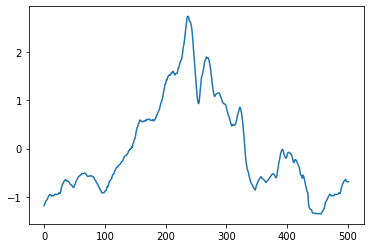

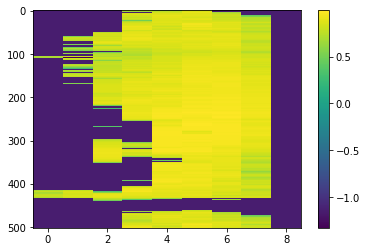

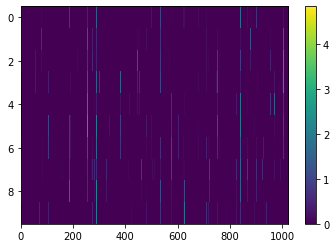

In [ ]:
# ic(train_dataloader[0][0].shape)
# ic(val_dataloader[0][0].shape)
b = train_dataloader[3]
ic(len(b))
ic(len(b[0]))
ic(np.shape(b[0][0]))
ic(np.shape(b[0][1]))
ic(np.shape(b[0][2]))

plt.figure()
plt.plot(b[0][1][0])
plt.figure()
plt.imshow(b[0][2][0], interpolation='nearest', aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(b[0][0][0], interpolation='nearest', aspect='auto')
plt.colorbar()

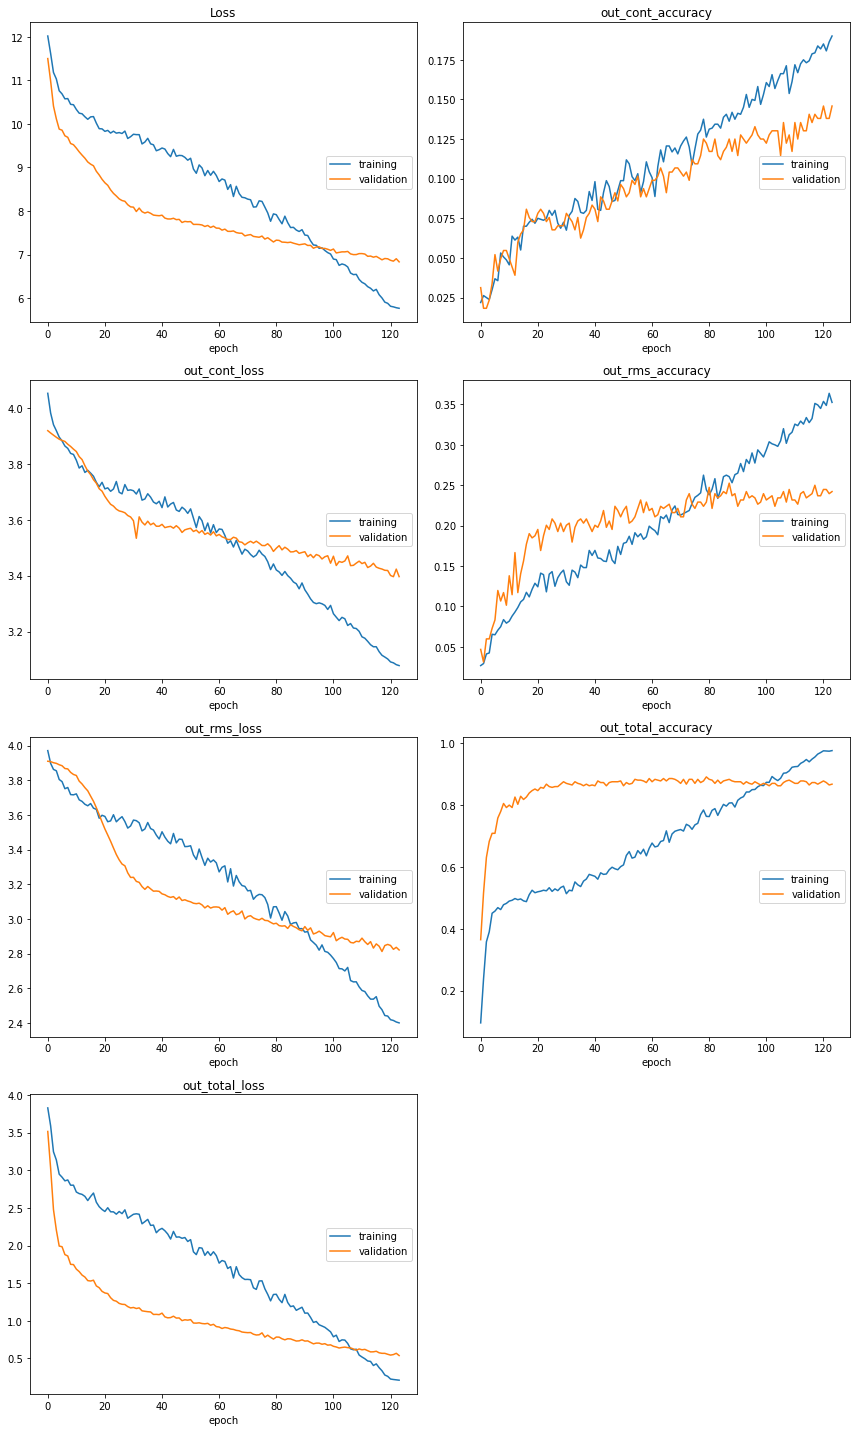

Loss
	training         	 (min:    5.765, max:   12.019, cur:    5.765)
	validation       	 (min:    6.831, max:   11.501, cur:    6.831)
out_cont_accuracy
	training         	 (min:    0.022, max:    0.190, cur:    0.190)
	validation       	 (min:    0.018, max:    0.146, cur:    0.146)
out_cont_loss
	training         	 (min:    3.078, max:    4.053, cur:    3.078)
	validation       	 (min:    3.396, max:    3.919, cur:    3.397)
out_rms_accuracy
	training         	 (min:    0.027, max:    0.364, cur:    0.352)
	validation       	 (min:    0.031, max:    0.253, cur:    0.242)
out_rms_loss
	training         	 (min:    2.401, max:    3.971, cur:    2.401)
	validation       	 (min:    2.813, max:    3.910, cur:    2.821)
out_total_accuracy
	training         	 (min:    0.096, max:    0.976, cur:    0.976)
	validation       	 (min:    0.365, max:    0.891, cur:    0.867)
out_total_loss
	training         	 (min:    0.212, max:    3.827, cur:    0.212)
	validation       	 (min:    0.539, max: 

In [ ]:
mixed_net = make_MixedNet()
#fit the model
history = mixed_net.fit(train_dataloader, 
                    epochs=epochs,
                    callbacks=[PlotLossesKeras(), 
                               reduce_lr,
                               ],
                    validation_data = val_dataloader,
                    verbose=1)

In [ ]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

# Using only transfer learning and no mixed features

In [16]:
crop = FRAMES

def make_tfYAMNet():
    act = 'relu'

    input_shape = (crop,96,3)

    input_inf = layers.Input(shape=(None,1024))
    
    inf = layers.GlobalAveragePooling1D()(input_inf)
    inf = tf.expand_dims(inf, axis=-1)
    # inf = layers.Dense(10, activation='relu')(input_inf)
    # inf = layers.Conv1D(8, kernel_size=64, padding='same', activation='relu')(input_inf)
    # inf = layers.MaxPool1D()(inf)
    # inf = layers.Conv1D(8, kernel_size=64, padding='same', activation='relu')(inf)
    # inf = layers.MaxPool1D()(inf)

    # # rms = layers.Dense(10, activation='relu')(input_rms)
    # rms = layers.Conv1D(16, kernel_size=9, padding='same',)(input_rms)
    # # rms = layers.BatchNormalization()(rms)
    # rms = layers.ReLU()(rms)
    # rms = layers.AveragePooling1D()(rms)
    # rms = layers.Conv1D(32, kernel_size=9, padding='same',)(rms)
    # # rms = layers.BatchNormalization()(rms)
    # rms = layers.ReLU()(rms)
    # rms = layers.AveragePooling1D()(rms)
    # rms = layers.Conv1D(64, kernel_size=9, padding='same',)(rms)
    # # rms = layers.BatchNormalization()(rms)
    # rms = layers.ReLU()(rms)
    # # rms = layers.AveragePooling1D()(rms)
    # # rms = layers.Conv1D(64, kernel_size=9, padding='same', activation=act, )(rms)
    # # rms = layers.AveragePooling1D()(rms)
    # rms = layers.GlobalAveragePooling1D()(rms)
    # rms = tf.expand_dims(rms, axis=-1)
    # rms = layers.BatchNormalization()(rms)

    # out_rms = layers.Flatten()(rms)
    # out_rms = layers.Dense(50, activation='sigmoid', name='out_rms')(out_rms)
    # # rms = layers.Flatten()(rms)

    # # flat = layers.Dense(10, activation='relu')(input_flat)
    # cont = tf.expand_dims(input_cont, axis=-1)

    # cont = layers.Conv2D(4, kernel_size=(3,3), padding='same', kernel_regularizer='l2')(cont)
    # # cont = layers.BatchNormalization()(cont)
    # cont = layers.ReLU(6,)(cont)
    # cont = layers.MaxPool2D()(cont)
    # cont = layers.Conv2D(8, kernel_size=(3,3), padding='same', kernel_regularizer='l2')(cont)
    # # cont = layers.BatchNormalization()(cont)
    # cont = layers.ReLU(6,)(cont)
    # cont = layers.MaxPool2D()(cont)
    # cont = layers.Conv2D(16, kernel_size=(3,3), padding='same', kernel_regularizer='l2')(cont)
    # # cont = layers.BatchNormalization()(cont)
    # cont = layers.ReLU(6,)(cont)
    # # flat = layers.AveragePooling1D()(flat)
    # # flat = layers.Conv1D(64, kernel_size=9, padding='same', activation=act, )(flat)
    # # flat = layers.AveragePooling1D()(flat)
    # cont = layers.GlobalAveragePooling2D()(cont)
    # cont = tf.expand_dims(cont, axis=-1)
    # cont = layers.BatchNormalization()(cont)

    # out_cont = layers.Flatten()(cont)
    # out_cont = layers.Dense(50, activation='sigmoid', name='out_cont')(out_cont)
    # # cont = layers.Flatten()(cont)

    # z = layers.concatenate([inf,rms,cont], axis=1)
    z = layers.Flatten()(inf)
    z = layers.Dense(100, activation='relu',)(z)
    z = layers.Dense(50, activation='relu',)(z)
    # z = layers.BatchNormalization()(z)
    z = layers.Dense(50, activation='softmax', name='out_total')(z)

    
    model = keras.Model(inputs=input_inf, outputs=z)
    # model = keras.Model(inputs=[input_inf, input_rms, input_flat], outputs=z)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
      loss = tf.keras.losses.categorical_crossentropy, 
      metrics=['accuracy'])
    return model

tfyam_net = make_tfYAMNet()
tfyam_net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, 1024)]      0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 1024)              0         
_________________________________________________________________
tf.expand_dims_1 (TFOpLambda (None, 1024, 1)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               102500    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
out_total (Dense)            (None, 50)                2550  

In [19]:
SOURCE = path_batch

batch_size = 64
epochs = 200

fold = 2
# feat_names  = os.listdir(path_drive)
feat_names  = os.listdir(SOURCE)
ic(len(feat_names))

# not using augmentated samples here
val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
train_names = [x for x in feat_names if x[0]!=str(fold) and (x.endswith('0.npy'))]

# val_names = [x for x in feat_names if x[0]==str(fold) and x.endswith('0.npy')]
# train_names = [x for x in feat_names if x[0]!=str(fold)]
ic(len(train_names))
ic(len(val_names))

train_dataloader = FeatureSequence_reduced(train_names, SOURCE, batch_size, crop=None, with_mixup=True)
val_dataloader = FeatureSequence_reduced(val_names, SOURCE, batch_size, crop=None)
# feature_sequence = FeatureSequence(this_fold_names, path_batch, batch_size, with_mixup=True)

ic(len(train_dataloader))
ic(len(val_dataloader))

# TODO need to fine tune this
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=3, min_lr=0.0001)

ic| len(feat_names): 2000
ic| len(train_names): 1600
ic| len(val_names): 400
ic| len(train_dataloader): 25
ic| len(val_dataloader): 6


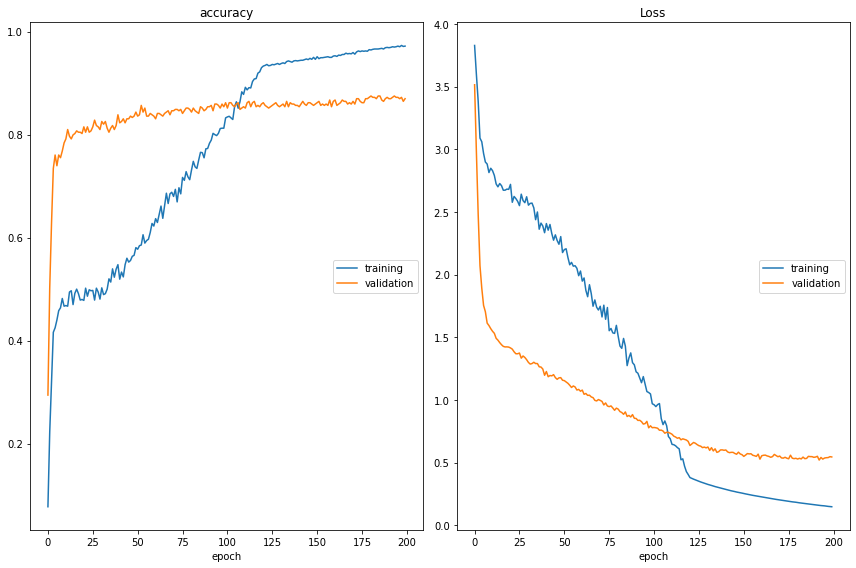

accuracy
	training         	 (min:    0.078, max:    0.973, cur:    0.972)
	validation       	 (min:    0.294, max:    0.875, cur:    0.870)
Loss
	training         	 (min:    0.147, max:    3.828, cur:    0.147)
	validation       	 (min:    0.519, max:    3.514, cur:    0.544)


In [20]:
tfyam_net = make_tfYAMNet()
#fit the model
history = tfyam_net.fit(train_dataloader, 
                    epochs=epochs,
                    callbacks=[PlotLossesKeras(), 
                               reduce_lr,
                               ],
                    validation_data = val_dataloader,
                    verbose=1)